In [1]:
import math
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
def plot_grid():
    plt.minorticks_on()
    #  Определяем внешний вид линий основной сетки:
    plt.grid(which='major',
        color = 'k', 
        linewidth = 1)

    #  Определяем внешний вид линий вспомогательной сетки:
    plt.grid(which='minor', 
        color = 'k', 
        linestyle = ':')

# The g_h filter

In [3]:
def g_h_filter (data, x0, dx, g, h, dt=1., pred=None):
    """
    Performs g-h filter on 1 state variable with a fixed g and h.
    ’data’ contains the data to be filtered.
    ’x0’ is the initial value for our state variable
    ’dx’ is the initial change rate for our state variable
    ’g’ is the g-h’s g scale factor
    ’h’ is the g-h’s h scale factor
    ’dt’ is the length of the time step
    ’pred’ is an optional list. If provided, each prediction will
    be stored in it
    """
    
    result = []
    x = x0
    dx = dx
    for z in data:
        x_est = x + dx*dt
        err_est = z - x_est
        dx = dx + err_est*h/dt
        x = x_est + err_est*g
        result.append(x)
    return result
        

In [4]:
def gen_data (x0, dx, count, noise_factor=0, accel=0):
    """
    Simulate measure data with noise
    'x0' start point
    'dx' data step
    'count' number of data
    'noise_factor' noise amplitude
    """
    return [x0+n*(dx+accel*n)+
            rnd.sample()*2*noise_factor-noise_factor
                for n in range(count)]

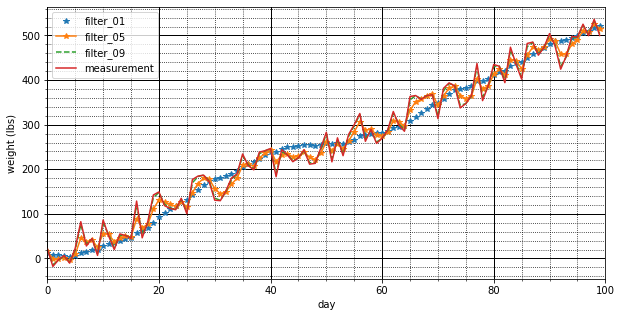

In [5]:
measure = gen_data(10, 5, 100, 50)
filtered_data_g01 = g_h_filter(measure, x0=10, dx=0, g=0.1, h = 0.02, dt=1.)
filtered_data_g05 = g_h_filter(measure, x0=10, dx=0, g=0.5, h = 0.02, dt=1.)
filtered_data_g09 = g_h_filter(measure, x0=10, dx=0, g=0.9, h = 0.02, dt=1.)

plt.rcParams['figure.figsize'] = [10, 5]
plt.xlim([0,100])
plt.xlabel('day')
plt.ylabel('weight (lbs)')
plot_grid()

plt.plot (filtered_data_g01, '*', label='filter_01')
plt.plot (filtered_data_g05, '*-', label='filter_05')
plt.plot (filtered_data_g09, '--', label='filter_09')
plt.plot(measure, label='measurement')
plt.legend()



In [6]:
pos = np.array([0.2]*10)
pos

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

# Discrete Bayes Filter

In [7]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [8]:
def normalize(p):
    s = sum(p)
    for i in range (len(p)):
        p[i] = p[i] / s

def update(pos, measure, p_hit, p_miss):
    q = np.array(pos, dtype=float)    
    for i in range(len(hallway)):
        if hallway[i] == measure:
            q[i] = pos[i] * p_hit
        else:
            q[i] = pos[i] * p_miss
    normalize(q)
    return q

In [9]:
def predict(pos, move, p_correct, p_under, p_over):
    n = len(pos)
    result = np.array(pos, dtype=float)
    for i in range(n):
        result[i] = \
            pos[(i-move) % n] * p_correct + \
            pos[(i-move-1) % n] * p_over + \
            pos[(i-move+1) % n] * p_under
    return result

In [10]:
pos = np.array([0.2]*10)
reading = 0 # 1 is ’door’
pos = update(pos, reading, .6, .2)
print('sum =', sum(pos))
print('probability of door =', pos[0])
print('probability of wall =', pos[2])

sum = 0.9999999999999999
probability of door = 0.04166666666666667
probability of wall = 0.12499999999999999


In [11]:
p = np.array([.1]*10)
p = update(p, 1, .6, .2)
print(p)
p = predict(p, 1, .8, .1, .1)
print(p)

[0.1875 0.1875 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.1875 0.0625]
[0.0875 0.175  0.175  0.075  0.0625 0.0625 0.0625 0.0625 0.075  0.1625]


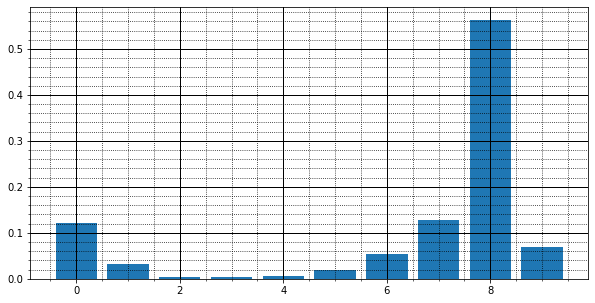

In [12]:
p = np.array([.1]*10)
p = update(p, 1, .6, .2)
p = predict(p, 1, .8, .1, .1)
p = update(p, 1, .6, .2)
p = predict(p, 1, .8, .1, .1)
p = update(p, 0, .6, .2)
p = predict(p, 1, .8, .1, .1)
p = update(p, 0, .6, .2)
p = predict(p, 1, .8, .1, .1)
p = update(p, 0, .6, .2)
p = predict(p, 1, .8, .1, .1)
p = update(p, 0, .6, .2)
p = predict(p, 1, .8, .1, .1)
p = update(p, 0, .6, .2)
p = predict(p, 1, .8, .1, .1)
p = update(p, 0, .6, .2)
p = predict(p, 1, .8, .1, .1)
p = update(p, 1, .6, .2)

plt.bar(np.array(range(10)),p)
plot_grid()

# Kalman Filter

In [13]:
class DogSensor(object):
    def __init__(self, x0=0, velocity=1, noise=0.0):
        """ x0 - initial position
        velocity - (+=right, -=left)
        noise - scaling factor for noise, 0== no noise
        """
        self.x = x0
        self.velocity = velocity
        self.noise = math.sqrt(noise)
    def sense(self):
        self.x = self.x + self.velocity
        return self.x + np.random.randn() * self.noise

In [14]:
def multiply(mu1, var1, mu2, var2):
    mean = (var1*mu2 + var2*mu1) / (var1+var2)
    variance = 1 / (1/var1 + 1/var2)
    return (mean, variance)

In [15]:
def test_sensor(noise_scale):
    dog = DogSensor (noise=noise_scale)
    xs = []
    for i in range(100):
        x = dog.sense()
        xs.append(x)

    plt.plot(xs, label='dog position')
    plt.plot([0,99],[1,100], 'r--', label='actual')
    plt.legend(loc='best')
    plt.title ('noise = {}'.format(noise_scale))    
    
    plot_grid()
    plt.show()

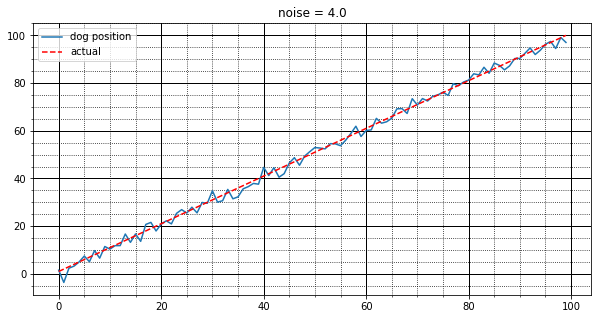

In [16]:
test_sensor(4.0)

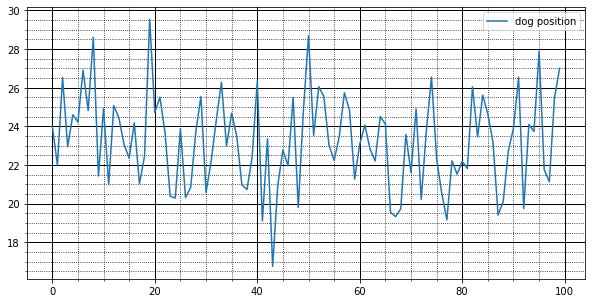

In [17]:
dog = DogSensor(23, 0, 5)
xs = range(100)
ys = []
for i in xs:
    ys.append(dog.sense())
plt.plot(xs,ys, label='dog position')
plt.legend(loc='best')

plot_grid()
plt.show()

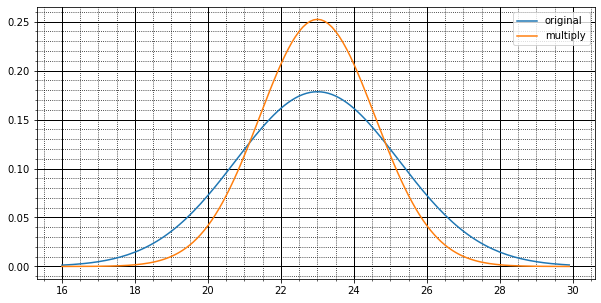

In [18]:
xs = np.arange(16, 30, 0.1)
m1,v1 = 23, 5
m, v = multiply(m1,v1,m1,v1)
ys = [norm(m1, math.sqrt(v1)).pdf(x) for x in xs]
# ys = [stats.gaussian(x,m1,v1) for x in xs]
plt.plot (xs, ys, label='original')
ys = [norm(m, math.sqrt(v)).pdf(x) for x in xs]
# ys = [stats.gaussian(x,m,v) for x in xs]
plt.plot (xs, ys, label='multiply')
plt.legend(loc='best')

plot_grid()
plt.show()


In [19]:
def update_dog(dog_pos, dog_variance, measurement, measurement_variance):
    return multiply(dog_pos, dog_variance, measurement, measurement_variance)

def predict_dog(pos, variance, movement, movement_variance):
    return (pos + movement, variance + movement_variance)

In [20]:
dog = DogSensor(x0 = 0, velocity=0, noise=1)
pos, variance = 10, 5
meas_variance = 5
result = 'time: {} \tposition = {:=1.3} \tvariance = {:=1.3}'
for i in range(20):
    pos,variance = update_dog(pos, variance, dog.sense(), meas_variance)
    print(result.format(i, pos, variance))

time: 0 	position = 5.03 	variance = 2.5
time: 1 	position = 3.44 	variance = 1.67
time: 2 	position = 2.65 	variance = 1.25
time: 3 	position = 1.89 	variance = 1.0
time: 4 	position = 1.4 	variance = 0.833
time: 5 	position = 1.27 	variance = 0.714
time: 6 	position = 1.13 	variance = 0.625
time: 7 	position = 1.08 	variance = 0.556
time: 8 	position = 1.07 	variance = 0.5
time: 9 	position = 0.866 	variance = 0.455
time: 10 	position = 0.752 	variance = 0.417
time: 11 	position = 0.657 	variance = 0.385
time: 12 	position = 0.566 	variance = 0.357
time: 13 	position = 0.53 	variance = 0.333
time: 14 	position = 0.459 	variance = 0.312
time: 15 	position = 0.551 	variance = 0.294
time: 16 	position = 0.599 	variance = 0.278
time: 17 	position = 0.609 	variance = 0.263
time: 18 	position = 0.54 	variance = 0.25
time: 19 	position = 0.552 	variance = 0.238


In [21]:
class KalmanFilter1D:
    """
    x - current state
    x0 - start state
    P - variance of the state
    R - variance of the measurement
    Q - variance of the prediction
    """
    def __init__(self, x0, P, R, Q):
        self.x = x0
        self.P = P
        self.R = R
        self.Q = Q
    def update(self, z):
        self.x = (self.P * z + self.x * self.R) / (self.P + self.R)
        self.P = 1 / (1/self.P + 1/self.R)
    def predict(self, u):
        self.x += u
        self.P += self.Q
    def get_estimate(self):
        return self.x

In [22]:
def volt(temp_variance):
    return np.random.randn()*temp_variance + 16.3

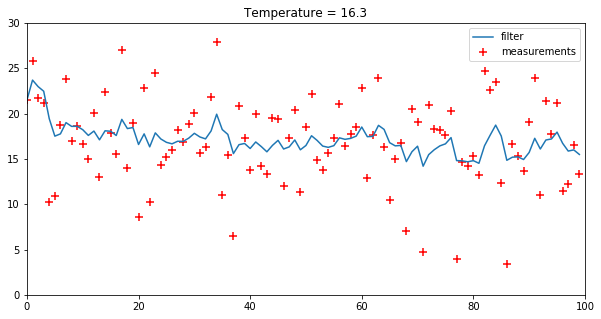

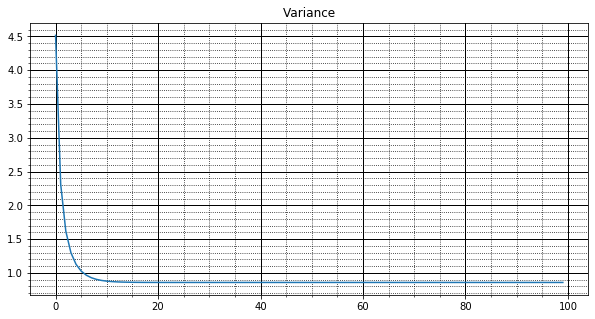

In [23]:
temp_variance = 2.13**2
movement_error = .2
movement = 0
N=100
zs = [volt(temp_variance) for i in range(N)]
ps = []
estimates = []
kf = KalmanFilter1D(x0=25, # initial state
                    P = 1000, # initial variance - large says ’who k
                    R=temp_variance, # sensor noise
                    Q=movement_error # movement noise
                   ) 
for i in range(N):
    kf.predict(movement)
    kf.update(zs[i])

    # save for latter plotting
    estimates.append(kf.x)
    ps.append(kf.P)

# plot the filter output and the variance
plt.scatter(range(N), 
            zs, 
            marker='+', s=64, color='r', label='measurements')
p1, = plt.plot(estimates, label='filter')
plt.title('Temperature = {}'.format(16.3))
plt.legend(loc='best')
plt.xlim((0,N));plt.ylim((0,30))
plt.show()
plt.plot(ps)
plt.title('Variance')
plot_grid()
plt.show()

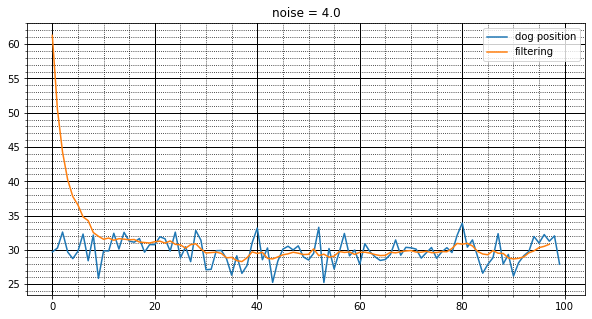

In [24]:
noise_sensor = 4.0
dog = DogSensor (x0 = 30, velocity=0, noise=noise_sensor)
movement = 0
Z = []
for i in range(100):
    z = dog.sense()
    Z.append(z)
    
kf_1D = KalmanFilter1D(x0=100, # initial state
                       P = 12, # initial variance - large says ’who k
                       R= 10, # sensor noise
                       Q= 0.5 # movement noise
                      )    
dog_est = [];
for i in range(1, len(Z[1:])):
    kf_1D.predict(movement)
    kf_1D.update(Z[i])
    # save for latter plotting
    dog_est.append(kf_1D.get_estimate())

plt.plot(Z, label='dog position')
plt.plot(dog_est, label='filtering')
plt.legend(loc='best')
plt.title ('noise = {}'.format(noise_sensor))    
    
plot_grid()
plt.show()

# Multivariate Kalman Filters

In [31]:
class KalmanFilter:
    def __init__(self, dim_x, dim_z, dim_u=0):
        """        
        Create a Kalman filter. You are responsible for setting the
        various state variables to reasonable values; the defaults below will
        not give you a functional filter.
        Parameters
        ----------
        dim_x : int
        Number of state variables for the Kalman filter. For example, if
        you are tracking the position and velocity of an object in two
        dimensions, dim_x would be 4.
        This is used to set the default size of P, Q, and u
        dim_z : int
        Number of of measurement inputs. For example, if the sensor
        provides you with position in (x,y), dim_z would be 2.
        dim_u : int (optional)
        size of the control input, if it is being used.
        Default value of 0 indicates it is not used.
        """ 
        
        self.x = np.zeros((dim_x,1)) # state
        self.P = np.eye(dim_x) # uncertainty covariance
        self.Q = np.eye(dim_x) # process uncertainty
        self.u = np.zeros((dim_x,1)) # motion vector
        self.B = 0 # control transition matrix
        self.F = 0 # state transition matrix
        self.H = 0 # Measurement function
        self.R = np.eye(dim_z) # state uncertainty
        
        # identity matrix. Do not alter this.
        self._I = np.eye(dim_x)
#         if use_short_form:
#             self.update = self.update_short_form
    def update(self, Z, R=None):
        """
        Add a new measurement (Z) to the kalman filter. If Z is None, nothing
        is changed.
        Parameters
        ---------
        Z : np.array
        measurement for this update.
        R : np.array, scalar, or None
        Optionally provide R to override the measurement noise for this
        one call, otherwise self.R will be used.
        """      
        
        if Z is None:
            return

        if R is None:
            R = self.R
        elif np.isscalar(R):
            R = np.eye(self.dim_z) * R
        
        # error (residual) between measurement and prediction
        y = Z - np.dot(self.H, self.x)
        print('y= {}'.format(y))
        
        # project system uncertainty into measurement space
        S = np.dot(self.H, self.P).dot(self.H.T) + R
        print('S= {}'.format(S))
        
        # map system uncertainty into kalman gain
        K = np.dot(self.P, self.H.T).dot(np.linalg.inv(S))
        print('K= {}'.format(K))
        
        # predict new x with residual scaled by the kalman gain
        self.x = self.x + np.dot(K, y)
        print('x= {}'.format(self.x))
        
        I_KH = self._I - np.dot (K, self.H)
        self.P = np.dot(I_KH, self.P).dot(I_KH.T) + \
            np.dot(K, R).dot(K.T)
        print('P= {}'.format(self.P))

    def predict(self, u=0):
        """
        Predict next position.
        Parameters
        ----------
        u : np.array
        Optional control vector. If non-zero, it is multiplied by B
        to create the control input into the system.
        """
        
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = self.F.dot(self.P).dot(self.F.T) + self.Q

In [26]:
def Q_DWPA(dim, dt=1., sigma=1.):
    """ 
    Returns the Q matrix for the Discrete Wiener Process Acceleration M
    dim may be either 2 or 3, dt is the time step, and sigma is the varianc
    the noise
    """
    
    assert dim == 2 or dim == 3
    if dim == 2:
        Q = np.array([[.25*dt**4, .5*dt**3],
                      [ .5*dt**3, dt**2]
                     ], dtype=float)
    else:
        Q = np.array([[.25*dt**4, .5*dt**3, .5*dt**2],
                      [ .5*dt**3, dt**2, dt],
                      [ .5*dt**2, dt, 1]
                     ], dtype=float)
    return Q * sigma

y= [[29.78756026]]
S= [[1005.]]
K= [[0.99502488]
 [0.49751244]]
x= [[29.63936344]
 [14.81968172]]
P= [[  4.97512438   2.48756219]
 [  2.48756219 251.24378109]]
y= [[-14.20131443]]
S= [[266.19402985]]
K= [[0.98121671]
 [0.95318195]]
x= [[30.52447816]
 [ 1.2832452 ]]
P= [[4.90608354 4.76590973]
 [4.76590973 9.39164564]]
y= [[0.69619211]]
S= [[28.82954864]]
K= [[0.82656683]
 [0.49107794]]
x= [[32.38317267]
 [ 1.62512979]]
P= [[4.13283415 2.4553897 ]
 [2.4553897  2.43918251]]
y= [[-3.50512105]]
S= [[16.48279606]]
K= [[0.69665341]
 [0.29695036]]
x= [[31.56644793]
 [ 0.58428283]]
P= [[3.48326704 1.4847518 ]
 [1.4847518  0.98573753]]
y= [[-1.62346902]]
S= [[12.43850817]]
K= [[0.59802253]
 [0.19861621]]
x= [[31.17985971]
 [ 0.26183557]]
P= [[2.99011267 0.99308104]
 [0.99308104 0.49505831]]
y= [[1.93560359]]
S= [[10.47133306]]
K= [[0.52250588]
 [0.14211556]]
x= [[32.45305953]
 [ 0.53691496]]
P= [[2.61252938 0.7105778 ]
 [0.7105778  0.28357055]]
y= [[0.23985843]]
S= [[9.31725553]]
K= [[0.4633612

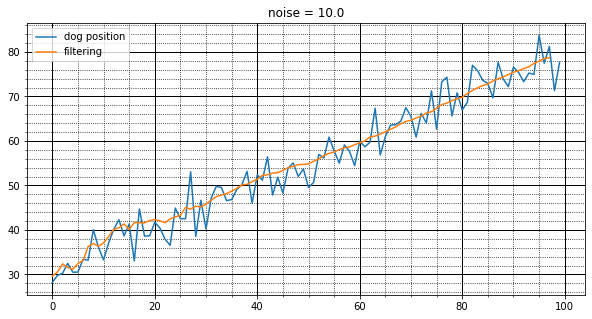

In [32]:
noise_sensor = 10.0
dog = DogSensor (x0 = 30, velocity=0.5, noise=noise_sensor)

dog_filter = KalmanFilter (dim_x=2, dim_z=1)

dog_filter.x = np.array([[0], [0]]) # initial state (location and velocity)
dog_filter.F = np.array([[1,1], [0,1]]) # state transition matrix
dog_filter.H = np.array([[1,0]]) # Measurement function
dog_filter.R *= 5 # measurement noise
dog_filter.Q = Q_DWPA(2, sigma=0.) # process noise
dog_filter.P *= 500. # covariance matrix


Z = []
for i in range(100):
    z = dog.sense()
    Z.append(z)

dog_est = [];
for i in range(1, len(Z[1:])):
    
    dog_filter.predict()
    dog_filter.update(Z[i])
    # save for latter plotting
    dog_est.append(dog_filter.x[0, 0])

plt.plot(Z, label='dog position')
plt.plot(dog_est, label='filtering')
plt.legend(loc='best')
plt.title ('noise = {}'.format(noise_sensor))    
    
plot_grid()
plt.show() 

In [28]:
x = np.array([[1,2],[3,4]], dtype=float)
y = np.array([[1,2],[3,4]], dtype=float)
x.dot(y)

array([[ 7., 10.],
       [15., 22.]])